#Variational Quantum Eigensolver(VQE)、QAOAセミナー 2-2（VQEで量子化学計算編）

量子化学計算はハミルトニアンの作成をパウリ行列を使って行い、VQEを利用して解を得ることができます。量子化学計算はハミルトニアンに対応するansatzの研究が進んでおり、課題として見通しが他の問題よりもよくなっています。

##2-3-1 追加のインストール
追加でツールのインストールが必要です。
今回は、blueqatに追加で、openfermionblueqatとopenfermionを追加します。

In [1]:
!pip3 install blueqat openfermionblueqat openfermion

     |████████████████████████████████| 51kB 2.4MB/s 
     |████████████████████████████████| 634kB 8.8MB/s 
  Created wheel for openfermion: filename=openfermion-0.10.0-cp36-none-any.whl size=731375 sha256=b376fd0f66f7ad4e2d5b4244a8ed6bdfe83674c2cb123f62b0f58ab24af5c6b9
  Stored in directory: /root/.cache/pip/wheels/3c/49/cd/098bb337ffcbb70021864403773043df332c065590873f1813
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-cp36-none-any.whl size=13825 sha256=170181c246083c6094378e11cb63d2801a0ba573cefb45615659e2c69fd0e1eb
  Stored in directory: /root/.cache/pip/wheels/10/4d/51/6b843681a9a5aef35f0d0fbce243de46f85080036e16118752
Successfully built openfermion pubchempy


##2-3-2 コードをざっくり
今回はopenfermionに準備されたコードを使います。

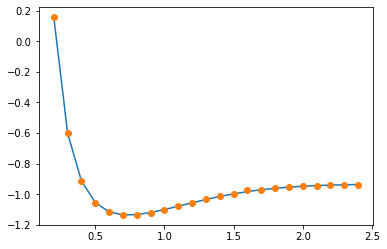

In [1]:
from blueqat import *
from openfermion import *
from openfermionblueqat import*
import numpy as np

def get_molecule(bond_len):
  geometry = [('H',(0.,0.,0.)),('H',(0.,0.,bond_len))]

  description = format(bond_len)
  molecule = MolecularData(geometry, "sto-3g",1,description=description)

  molecule.load()
  return molecule

x = [];e=[];fullci=[]
for bond_len in np.arange(0.2,2.5,0.1):
  m = get_molecule("{:.2}".format(bond_len))
  h = bravyi_kitaev(get_fermion_operator(m.get_molecular_hamiltonian()))
  runner = vqe.Vqe(UCCAnsatz(h,6,Circuit().x[0]))
  result = runner.run()
  x.append(bond_len)
  e.append(runner.ansatz.get_energy_sparse(result.circuit))
  fullci.append(m.fci_energy)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x,fullci)
plt.plot(x,e,"o")

今回は水素分子の原子の結合間の距離に応じて、各状態の安定エネルギーをVQEを用いて求めています。

##2-3-3 中身確認
MoluculearDataというのでOpenFermionに最初から入っているデータを使えるようです。H2でSto-3g系を読み込んでみます。

In [2]:
def get_molecule(bond_len):
  geometry = [('H',(0.,0.,0.)),('H',(0.,0.,bond_len))]

  description = format(bond_len)
  molecule = MolecularData(geometry, "sto-3g",1,description=description)

  molecule.load()
  return molecule

原子間距離が0.4のものを読み込んで、ハミルトニアンと呼ばれる基本の式が取得できます。

In [3]:
m = get_molecule(0.4)
m.get_molecular_hamiltonian()

() 1.322943021475
((0, 1), (0, 0)) -1.4820918858979102
((1, 1), (1, 0)) -1.4820918858979102
((2, 1), (2, 0)) -0.1187350527865787
((3, 1), (3, 0)) -0.1187350527865787
((0, 1), (0, 1), (0, 0), (0, 0)) 0.36843967630348756
((0, 1), (0, 1), (2, 0), (2, 0)) 0.08225771204699692
((0, 1), (1, 1), (1, 0), (0, 0)) 0.36843967630348756
((0, 1), (1, 1), (3, 0), (2, 0)) 0.08225771204699692
((0, 1), (2, 1), (0, 0), (2, 0)) 0.082257712046997
((0, 1), (2, 1), (2, 0), (0, 0)) 0.3626667179796745
((0, 1), (3, 1), (1, 0), (2, 0)) 0.082257712046997
((0, 1), (3, 1), (3, 0), (0, 0)) 0.3626667179796745
((1, 1), (0, 1), (0, 0), (1, 0)) 0.36843967630348756
((1, 1), (0, 1), (2, 0), (3, 0)) 0.08225771204699692
((1, 1), (1, 1), (1, 0), (1, 0)) 0.36843967630348756
((1, 1), (1, 1), (3, 0), (3, 0)) 0.08225771204699692
((1, 1), (2, 1), (0, 0), (3, 0)) 0.082257712046997
((1, 1), (2, 1), (2, 0), (1, 0)) 0.3626667179796745
((1, 1), (3, 1), (1, 0), (3, 0)) 0.082257712046997
((1, 1), (3, 1), (3, 0), (1, 0)) 0.362666717979674

こちらはパウリ行列の表現ではないので、今回VQEで計算できるように変換をします。

##2-3-4 量子コンピュータ向け変換
Bravi-Kitaev(ブラビキタエフ)変換やJordan–Wigner(ジョルダンウィグナー)変換がありますが、今回は前者のBK変換をして確認してみると、

In [4]:
h = bravyi_kitaev(get_fermion_operator(m.get_molecular_hamiltonian()))
print(h)

(0.7407724940116754+0j) [] +
(0.041128856023498556+0j) [X0 Z1 X2] +
(0.041128856023498556+0j) [X0 Z1 X2 Z3] +
(0.041128856023498556+0j) [Y0 Z1 Y2] +
(0.041128856023498556+0j) [Y0 Z1 Y2 Z3] +
(0.23528824284103544+0j) [Z0] +
(0.23528824284103542+0j) [Z0 Z1] +
(0.18133335898983727+0j) [Z0 Z1 Z2] +
(0.18133335898983727+0j) [Z0 Z1 Z2 Z3] +
(0.14020450296633868+0j) [Z0 Z2] +
(0.14020450296633868+0j) [Z0 Z2 Z3] +
(0.18421983815174378+0j) [Z1] +
(-0.45353118471995524+0j) [Z1 Z2 Z3] +
(0.19136084915706864+0j) [Z1 Z3] +
(-0.45353118471995524+0j) [Z2]


このようにきちんと変換されました。ちょっと複雑な形をしていますが、これこそがこれまで学んできたパウリ行列の和で書かれたハミルトニアンです。これをVQEにかけますが、今回はUCC理論と呼ばれる上記のハミルトニアンに対応するansatzがあるため効率的に計算ができます。

In [5]:
runner = vqe.Vqe(UCCAnsatz(h,2,Circuit().x[0]))
result = runner.run(verbose = True)

params: [0.85735393 0.26435293] val: -0.6509224068364255
params: [0.85735393 0.26435293] val: -0.6509224068364255
params: [1.85735393 0.26435293] val: 0.580869355567871
params: [-0.76068007  0.26435293] val: -0.20314413359369127
params: [0.85735393 0.26435293] val: -0.6509224068364255
params: [0.23931996 0.26435293] val: -0.903069815471201
params: [0.23931996 0.26435293] val: -0.903069815471201
params: [0.23931996 1.26435293] val: 0.14842057356438088
params: [ 0.23931996 -1.35368107] val: -0.004567951712909135
params: [0.23931996 0.26435293] val: -0.903069815471201
params: [ 0.23931996 -0.35368104] val: -0.650711608878654
params: [0.23931996 0.64631893] val: -0.3883091255946547
params: [0.23931996 0.07160234] val: -0.8618597217451346
params: [0.23931996 0.40169069] val: -0.8641588087465389
params: [0.23931996 0.23895891] val: -0.8966507378929758
params: [0.23931996 0.29002096] val: -0.9070474408999273
params: [-0.37871402  0.31568899] val: -0.553377933999168
params: [0.23931996 0.29002

最適化のプロセスが出てきました。パラメータが最適化されながら最小基底状態が探索されています。今回はansatzは量子化学の理論に基づいて電子の配置をするUCCansatzと呼ばれるものが利用されました。通常ansatzの構成は難しいので、理論的な探究が求まれます。最小エネルギーは、

In [6]:
runner.ansatz.get_energy_sparse(result.circuit)

-0.9129850551176981

原子間距離0.4の場合の最小値の期待値が求まりました。これを全体でやったのが最初のコードです。再掲します。

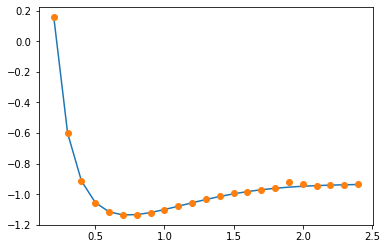

In [7]:
from blueqat import *
from openfermion import *
from openfermionblueqat import*
import numpy as np

def get_molecule(bond_len):
  geometry = [('H',(0.,0.,0.)),('H',(0.,0.,bond_len))]

  description = format(bond_len)
  molecule = MolecularData(geometry, "sto-3g",1,description=description)

  molecule.load()
  return molecule

x = [];e=[];fullci=[]
for bond_len in np.arange(0.2,2.5,0.1):
  m = get_molecule("{:.2}".format(bond_len))
  h = bravyi_kitaev(get_fermion_operator(m.get_molecular_hamiltonian()))
  runner = vqe.Vqe(UCCAnsatz(h,6,Circuit().x[0]))
  result = runner.run()
  x.append(bond_len)
  e.append(runner.ansatz.get_energy_sparse(result.circuit))
  fullci.append(m.fci_energy)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x,fullci)
plt.plot(x,e,"o")